In [1]:
import os
import sys
script_path = "../Libs/"
sys.path.append(os.path.abspath(script_path))
import numpy as np
import matplotlib.pyplot as plt
import librosa
import pylab
import librosa.display
import scipy.io.wavfile as wavio
import scipy.io as matio
from mel_utils import get_mel_spectrum, get_filterbanks, powspec, dumpFB_Array
from mel_utils import get_filterbank_from_midfreqs, framesig, genICFilterMatrix
from scipy import signal # audio processing
from scipy.fftpack import dct
import librosa # library for audio
from mel_utils import *
import skimage
from tqdm import tqdm
np.set_printoptions(threshold=sys.maxsize)

In [2]:
#ii = [3,4,5,6,7,8,9,19,25,29,33,34]
"""
0.0
195.0985245
251.8401972
312.1788118
376.342384
444.5733837
517.1296516
1550.447293
2554.078667
3461.030019
4620.759758
8000.0
"""
"""
python     index  
0	        0
44.37407701	1
91.56109503	2
141.7393707	3
195.0985245	4
251.8401972	5
312.1788118	6
376.342384	7
444.5733837	8
517.1296516	9
594.2853728	10
676.332114	11
763.5799243	12
856.3585075	13
955.0184679	14
1059.932635	15
1171.497473	16
1290.134577	17
1416.29227	18
1550.447293	19
1693.106609	20
1844.809319	21
2006.128697	22
2177.674359	23
2360.094564	24
2554.078667	25
2760.35972	26
2979.717247	27
3212.980185	28
3461.030019	29
3724.804114	30
4005.299255	31
4303.575414	32
4620.759758	33
4958.050905	34
5316.723458	35
5698.132815	36
6103.720298	37
6535.018596	38
6993.657556	39
7481.370346	40
8000	    41
"""

'\npython     index  \n0\t        0\n44.37407701\t1\n91.56109503\t2\n141.7393707\t3\n195.0985245\t4\n251.8401972\t5\n312.1788118\t6\n376.342384\t7\n444.5733837\t8\n517.1296516\t9\n594.2853728\t10\n676.332114\t11\n763.5799243\t12\n856.3585075\t13\n955.0184679\t14\n1059.932635\t15\n1171.497473\t16\n1290.134577\t17\n1416.29227\t18\n1550.447293\t19\n1693.106609\t20\n1844.809319\t21\n2006.128697\t22\n2177.674359\t23\n2360.094564\t24\n2554.078667\t25\n2760.35972\t26\n2979.717247\t27\n3212.980185\t28\n3461.030019\t29\n3724.804114\t30\n4005.299255\t31\n4303.575414\t32\n4620.759758\t33\n4958.050905\t34\n5316.723458\t35\n5698.132815\t36\n6103.720298\t37\n6535.018596\t38\n6993.657556\t39\n7481.370346\t40\n8000\t    41\n'

In [3]:
# os.path.abspath(script_path)
"""
https://stackoverflow.com/questions/40197060/librosa-mel-filter-bank-decreasing-triangles
"""

'\nhttps://stackoverflow.com/questions/40197060/librosa-mel-filter-bank-decreasing-triangles\n'

In [4]:
def get_custom_default_filterbanks(nfilt=40, nfft=1024, samplerate=16000, lowfreq=0, highfreq=8000):
    highfreq = highfreq or samplerate / 2
    """Compute log Mel-filterbank energy features from an audio signal.
    :param signal: the audio signal from which to compute features. Should be an N*1 array
    :param samplerate: the sample rate of the signal we are working with, in Hz.
    :param winlen: the length of the analysis window in seconds. Default is 0.025s (25 milliseconds)
    :param winstep: the step between successive windows in seconds. Default is 0.01s (10 milliseconds)
    :param nfilt: the number of filters in the filterbank, default 26.
    :param nfft: the FFT size. Default is 512.
    :param lowfreq: lowest band edge of mel filters. In Hz, default is 0.
    :param highfreq: highest band edge of mel filters. In Hz, default is samplerate/2
    :param preemph: apply preemphasis filter with preemph as coefficient. 0 is no filter. Default is 0.97.
    :param winfunc: the analysis window to apply to each frame. By default no window is applied. You can use np window functions here e.g. winfunc=np.hamming
    :returns: A np array of size (NUMFRAMES by nfilt) containing features. Each row holds 1 feature vector.
    """
    assert highfreq <= samplerate / 2, "highfreq is greater than samplerate/2"
    # compute points evenly spaced in mels
    lowmel = hz2mel_nature(lowfreq)
    highmel = hz2mel_nature(highfreq)
    melpoints = np.linspace(lowmel, highmel, nfilt + 2)
    # our points are in Hz, but we use fft bins, so we have to convert
    #  from Hz to fft bin number
    mid_freqs = mel2hz_nature(melpoints)

    bins = np.floor((nfft + 1) * mid_freqs / samplerate)
    fbank = np.zeros([nfilt, nfft // 2 + 1])
    for j in range(0, nfilt):
        for i in range(int(bins[j]), int(bins[j + 1])):
            fbank[j, i] = (i - bins[j]) / (bins[j + 1] - bins[j])
        for i in range(int(bins[j + 1]), int(bins[j + 2])):
            fbank[j, i] = (bins[j + 2] - i) / (bins[j + 2] - bins[j + 1])
    print("Middel Frequences are {}".format(mid_freqs))
    print("Bins are {}".format(bins))
    return fbank

In [5]:
get_custom_default_filterbanks()

Middel Frequences are [   0.           44.37407701   91.56109503  141.73937073  195.09852453
  251.84019719  312.17881177  376.34238398  444.57338374  517.12965156
  594.28537283  676.33211398  763.57992429  856.35850754  955.01846792
 1059.93263499 1171.49747253 1290.13457677 1416.29226959 1550.44729265
 1693.10660904 1844.80931898 2006.12869712 2177.67435884 2360.094564
 2554.07866662 2760.35971998 2979.71724669 3212.98018452 3461.03001887
 3724.80411386 4005.29925458 4303.57541383 4620.75975774 4958.05090523
 5316.72345751 5698.13281472 6103.72029792 6535.01859571 6993.65755619
 7481.37034603 8000.        ]
Bins are [  0.   2.   5.   9.  12.  16.  19.  24.  28.  33.  38.  43.  48.  54.
  61.  67.  75.  82.  90.  99. 108. 118. 128. 139. 151. 163. 176. 190.
 205. 221. 238. 256. 275. 296. 317. 340. 365. 391. 418. 448. 479. 512.]


array([[0.        , 0.5       , 1.        , 0.66666667, 0.33333333,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [6]:
def plot_FB(fb_matrix=None):
    midfreqs = [0.0,195.0985245,251.8401972,
                312.1788118,376.342384,444.5733837,
                517.1296516,1550.447293,2554.078667,
                3461.030019,4620.759758,8000.0]
    ten_melfb = get_filterbank_from_midfreqs(midfreqs)
#     print(ten_melfb.shape)
    melfb = get_custom_default_filterbanks()
    print(melfb)
    plt.figure(figsize=(30,15))
    plt.plot(melfb.T)
    
    melfb_40_dict = {"melfb":melfb}
    if not os.path.exists("./melfb_output/"):
        os.mkdir("./melfb_output")
    fb_out_path = "./melfb_output/melfb_40.mat"
    matio.savemat(fb_out_path,melfb_40_dict,oned_as='column')

[   0.         195.0985245  251.8401972  312.1788118  376.342384
  444.5733837  517.1296516 1550.447293  2554.078667  3461.030019
 4620.759758  8000.       ]
12
Middel Frequences are [   0.           44.37407701   91.56109503  141.73937073  195.09852453
  251.84019719  312.17881177  376.34238398  444.57338374  517.12965156
  594.28537283  676.33211398  763.57992429  856.35850754  955.01846792
 1059.93263499 1171.49747253 1290.13457677 1416.29226959 1550.44729265
 1693.10660904 1844.80931898 2006.12869712 2177.67435884 2360.094564
 2554.07866662 2760.35971998 2979.71724669 3212.98018452 3461.03001887
 3724.80411386 4005.29925458 4303.57541383 4620.75975774 4958.05090523
 5316.72345751 5698.13281472 6103.72029792 6535.01859571 6993.65755619
 7481.37034603 8000.        ]
Bins are [  0.   2.   5.   9.  12.  16.  19.  24.  28.  33.  38.  43.  48.  54.
  61.  67.  75.  82.  90.  99. 108. 118. 128. 139. 151. 163. 176. 190.
 205. 221. 238. 256. 275. 296. 317. 340. 365. 391. 418. 448. 479. 512.

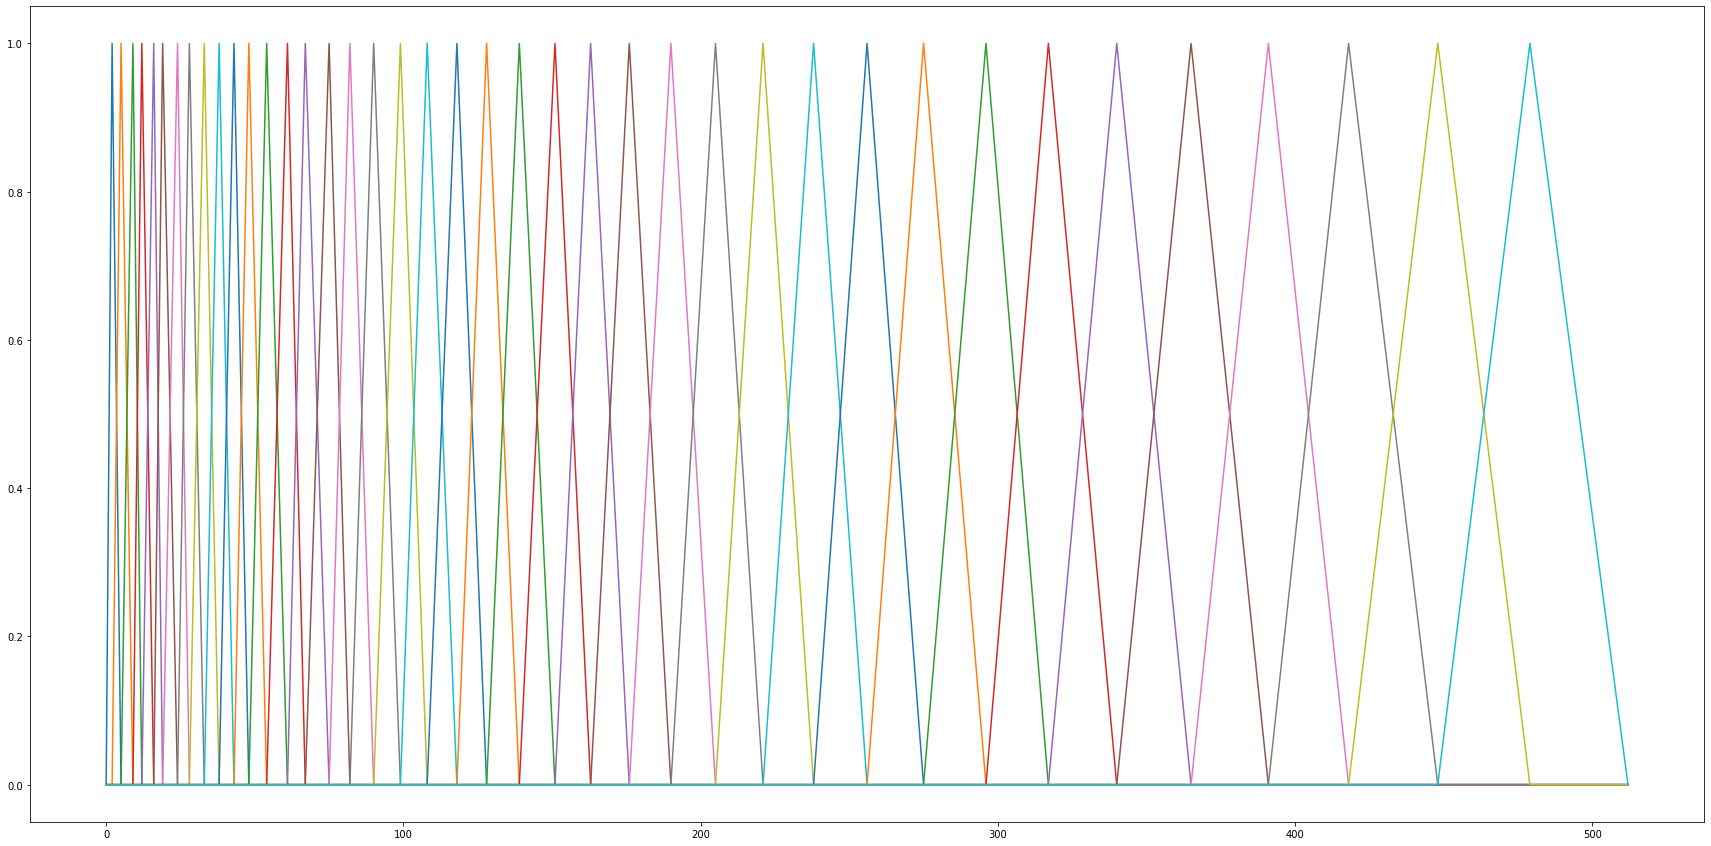

In [7]:
plot_FB()

In [8]:
def get_10_from_40_full_band_FB_from_MatFile(matfile):
    fb_save_path = "./melfb_output/"
    if not os.path.exists(fb_save_path):
        os.mkdir(fb_save_path)
    src_data = matio.loadmat(matfile)
    fb_matrix = src_data["melfb"]
    wanted_rows_12 = [2,3,4,5,6,7,8,18,24,28,32,33]
    wanted_rows_10 = [3,4,5,6,7,8,18,24,28,32]
    new_ary_list = []
    new_ary_list_2 = []
    for i in wanted_rows_10:
        new_ary_list.append(fb_matrix[i])
    for j in wanted_rows_12:
        new_ary_list_2.append(fb_matrix[j])
    wanted_fb_10 = np.array(new_ary_list)
    wanted_fb_12 = np.array(new_ary_list_2)
    melfb_10_file_path = fb_save_path+"melfb_10.mat"
    melfb_12_file_path = fb_save_path+"melfb_12.mat"
    melfb_10_dict = {"melfb10":wanted_fb_10}
    melfb_12_dict = {"melfb12":wanted_fb_12}
    matio.savemat(melfb_10_file_path,melfb_10_dict,oned_as='column')
    matio.savemat(melfb_12_file_path,melfb_12_dict,oned_as='column')
#     print(wanted_fb_12.shape)
#     print(wanted_fb_10.shape)
    # draw the original fb 
    plt.figure(figsize=(30,15))
    plt.subplot(211)
    plt.plot(wanted_fb_12.T)
    plt.subplot(212)
    plt.plot(wanted_fb_10.T)

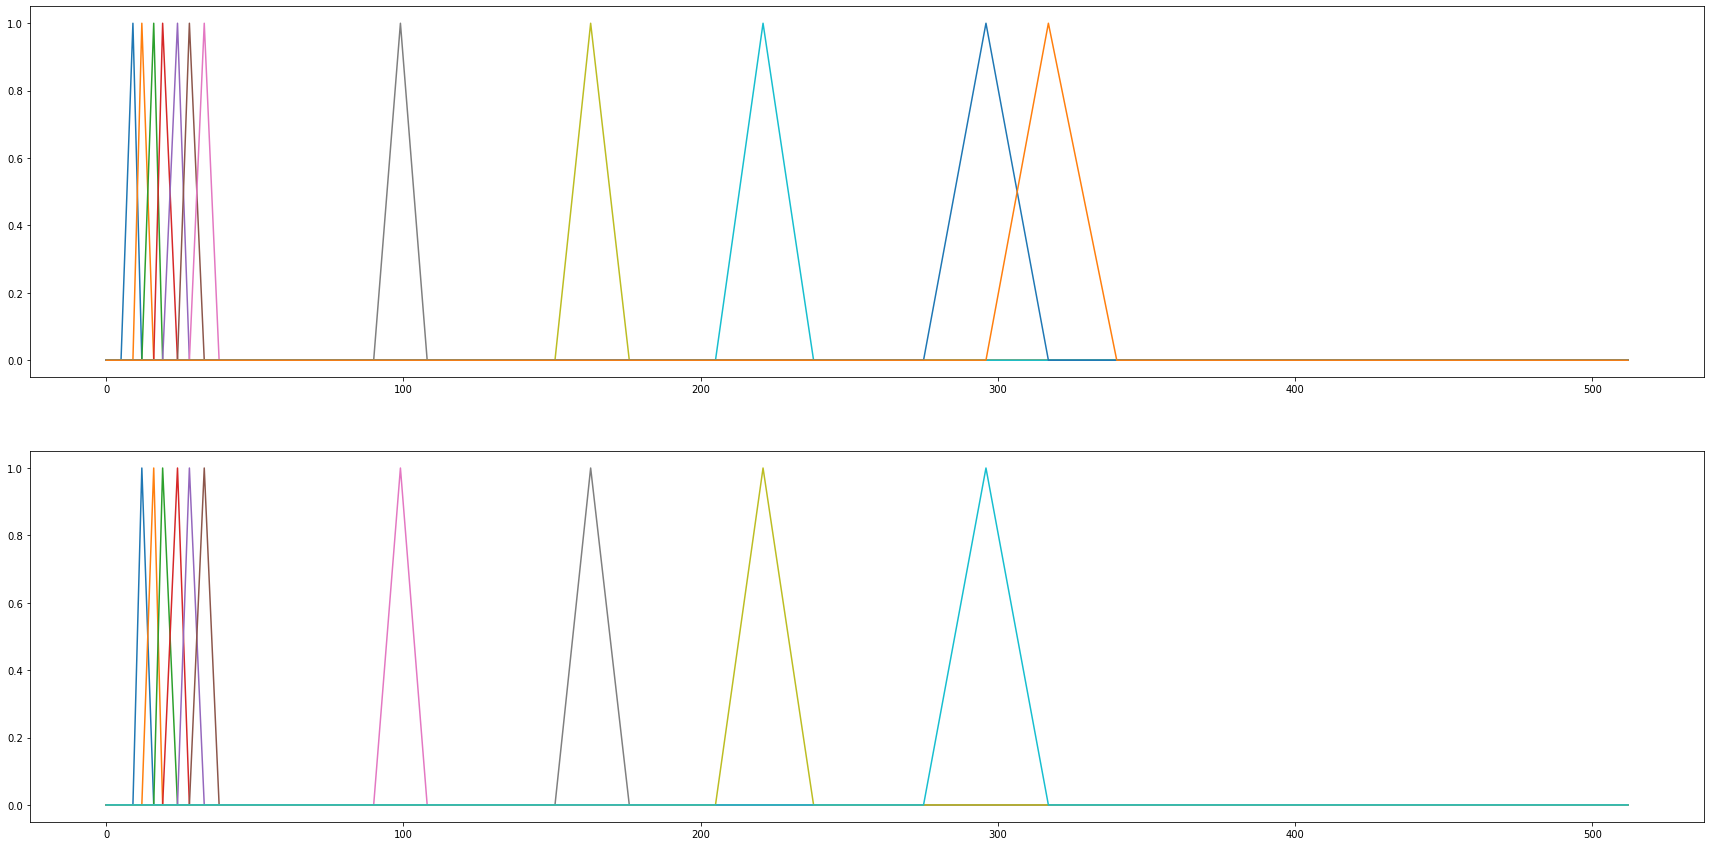

In [9]:
fb_mat_file = "./melfb_output/melfb_40.mat"
get_10_from_40_full_band_FB_from_MatFile(fb_mat_file)

In [12]:
fb_cfile_save_path = "./fb_hfile_output/fb.h"
theMelFB = matio.loadmat("./melfb_output/melfb_10.mat")["melfb10"]
if not os.path.exists("./fb_hfile_output/"):
    os.mkdir("./fb_hfile_output/")
dumpFB_Array(FB=theMelFB, fb_save_path=fb_cfile_save_path)